## Here we plot three beams of ATL06 data over a Landsat 8 OLI image of Edgeworth Glacier, Antarctica.

### Start with the Landsat scene...

In [2]:
### Now to download it, open the terminal in jupyter labs and type:
# need this to be real /home/jovyan/data/


!mkdir -p /home/jovyan/data/

!aws --no-sign-request s3 cp s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/LC08_L1GT_217105_20171203_20171207_01_T2_B8.TIF /home/jovyan/data/ #pan
!aws --no-sign-request s3 cp s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/LC08_L1GT_217105_20171203_20171207_01_T2_B4.TIF /home/jovyan/data/ #red
!aws --no-sign-request s3 cp s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/LC08_L1GT_217105_20171203_20171207_01_T2_B3.TIF /home/jovyan/data/ #green
!aws --no-sign-request s3 cp s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/LC08_L1GT_217105_20171203_20171207_01_T2_B2.TIF /home/jovyan/data/ #blue



download: s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/LC08_L1GT_217105_20171203_20171207_01_T2_B8.TIF to ../data/LC08_L1GT_217105_20171203_20171207_01_T2_B8.TIF
download: s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/LC08_L1GT_217105_20171203_20171207_01_T2_B4.TIF to ../data/LC08_L1GT_217105_20171203_20171207_01_T2_B4.TIF
download: s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/LC08_L1GT_217105_20171203_20171207_01_T2_B3.TIF to ../data/LC08_L1GT_217105_20171203_20171207_01_T2_B3.TIF
download: s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/LC08_L1GT_217105_20171203_20171207_01_T2_B2.TIF to ../data/LC08_L1GT_217105_20171203_20171207_01_T2_B2.TIF


In [3]:
# packages:
from pathlib import Path
import numpy as np
import cartopy.crs as ccrs
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import rasterio.mask
import pandas as pd
import h5py
from shapely.geometry import Point, Polygon
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'


## Landsat:
DATA_DIR = Path('/home/jovyan/data/')
LANDSAT_FILENAMES = [
    'LC08_L1GT_217105_20171203_20171207_01_T2_B4.TIF',
    'LC08_L1GT_217105_20171203_20171207_01_T2_B3.TIF',
    'LC08_L1GT_217105_20171203_20171207_01_T2_B2.TIF',
]
ROI_SHAPEFILE = 'shapefiles/edgeworth_polygons.kml'

# define cartopy crs for the raster
src_crs = ccrs.SouthPolarStereo(true_scale_latitude=-71)

# load roi shapefile for plotting and clipping image
gdf = gpd.read_file(ROI_SHAPEFILE).to_crs(src_crs.proj4_init)

rgb = []
for filename in LANDSAT_FILENAMES:
    with rasterio.open(DATA_DIR / filename, 'r') as src:
        # crop to our ROI
        im, transform = rasterio.mask.mask(src, gdf.geometry, crop=True)

        # move first axis to last
        im = np.moveaxis(im, 0, -1)

        # Set 0 values (no data) to nan
        im = im.astype(float)
        im[im == 0] = np.nan

        rgb.append(im)

# merge bands
rgb = np.dstack(rgb)
height, width, _ = rgb.shape

# mask zero values (no data)
mask = np.isnan(rgb)
rgb = np.ma.masked_where(mask, rgb)

# normalize
rgb = rgb / rgb.max()

# use mask as transparency array
flat_mask = np.logical_not(np.expand_dims(mask.any(axis=-1), axis=-1))
rgba = np.dstack([rgb, flat_mask])

# calculate extent of raster
xmin = transform[2]
xmax = transform[2] + transform[0] * width
ymin = transform[5] + transform[4] * height
ymax = transform[5]

# create figure
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=src_crs)

# plot raster
ax.imshow(
    rgba,
    origin='upper',
    extent=[xmin, xmax, ymin, ymax],
    transform=src_crs,
    interpolation='nearest',
)

# plot coastlines
#ax.coastlines(resolution='10m')

xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
gdf.boundary.plot(ax=ax, color=None);



# replot at the end with the trackes:
#icesat_in.plot(ax=ax,transform=ccrs.PlateCarree(),markersize=1,column=icesat_in['z'],cmap='viridis',vmax=200, vmin=0)

## Open the h5 file that was downloaded previously

Change the directory below to get an h5 file:

In [4]:
f=h5py.File('/home/jovyan/ALB_tests/ATL06_toplot/ATL06_20181015194309_02620112_001_01.h5', 'r')

In [5]:
# check out the keys....
f['gt1l/land_ice_segments'].keys()

<KeysViewHDF5 ['atl06_quality_summary', 'delta_time', 'h_li', 'h_li_sigma', 'latitude', 'longitude', 'segment_id', 'sigma_geo_h', 'bias_correction', 'dem', 'fit_statistics', 'geophysical', 'ground_track']>

In [6]:
# open the data, read in 3 different beams
with h5py.File('/home/jovyan/ALB_tests/ATL06_toplot/ATL06_20181015194309_02620112_001_01.h5', 'r') as f:  # open file
    x1 = f['gt1l/land_ice_segments/longitude'][:]                       # read data into memory
    y1 = f['gt1l/land_ice_segments/latitude'][:]                           # get pointer to data on disk
    z1 = f['gt1l/land_ice_segments/h_li'][:] 
    x2 = f['gt2l/land_ice_segments/longitude'][:]                      
    y2 = f['gt2l/land_ice_segments/latitude'][:]
    z2 = f['gt2l/land_ice_segments/h_li'][:] 
    x3 = f['gt3l/land_ice_segments/longitude'][:]                      
    y3 = f['gt3l/land_ice_segments/latitude'][:]
    z3 = f['gt3l/land_ice_segments/h_li'][:]  
#     print('x (in mem): ', x)
#     print('y (on disk):', y)
#     print('')
#     print('x (in mem): ', type(x))
#     print('y (on disk):', type(y))
#     print('')
#     print('x (in mem): ', x.shape)
#     print('y (on disk):', y.shape)  # same info from out-of-memory array
    

Here we concatenate the data (x,y,z) and add variable, b, in order to keep track of the beam. We then create a dataframe, df, using pandas.  Note that this is the entire graticule (?) and is not yet subset to our Edgeworth area of interest.

In [7]:
x=np.concatenate([x1,x2,x3],axis=0)
y=np.concatenate([y1,y2,y3],axis=0)
z=np.concatenate([z1,z2,z3],axis=0)
b=np.zeros(x.shape)

# you will be tempted to redefine these indices in the future
# do not do it.  python indices are weird and bruce has confirmed that these are right

ind1=len(x1)
ind2=len(x1)+len(x2)
ind3=len(x1)+len(x2)+len(x3)

# create the beam index:
b[0:ind1]=1
b[ind1:ind2]=2
b[ind2:ind3]=3

df = pd.DataFrame({'lon':x,'lat':y,'z':z,'b':b})

# get rid of no data values in z
df['z'][df['z']==df['z'].max()]=np.nan

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
# check out the stats... looks okay.
df.describe()

,lon,lat,z,b
count,148177.000000,148177.000000,142960.000000,148177.000000
mean,-57.252425,-70.978365,89.785454,1.983196
std,2.552570,5.473086,308.192749,0.817332
min,-60.572511,-79.001105,-223.322189,1.000000
25%,-59.505074,-76.830753,10.458408,1.000000
50%,-58.698345,-68.660850,18.140244,2.000000
75%,-54.684406,-66.026120,40.449673,3.000000
max,-52.612060,-61.928620,2041.332764,3.000000


Here we use David's tutorial, geospatial-analysis.ipynb, to create a "geometry."  This is really important for the subsetting (which will be done by spatial join) later 

In [9]:
# now create a new geometry for the lat, lon - we will use this to cut data 
df['geometry'] = list(zip(df['lon'], df['lat']))
df['geometry'] = df['geometry'].apply(Point)

In [10]:
# now create a geopandas database.
gdf_outline = gpd.GeoDataFrame(df, crs={'init' :'epsg:4326'})

Load in the kml file for the Edgeworth area of interest:

In [11]:
kml_filepath = str('/home/jovyan/crackup/shapefiles/edgeworth_simple-polygon.kml')

#Return a GeoDataFrame object
edw = gpd.read_file(kml_filepath)
#edw.head()

This is *THE THING*

In [12]:
icesat_in = gpd.sjoin(gdf_outline, edw, op='intersects', how='inner')

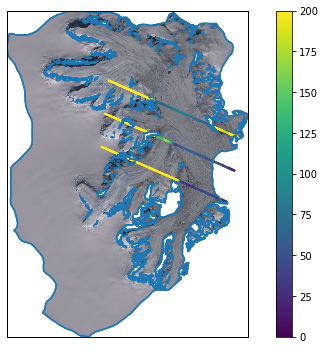

In [13]:
#%matplotlib widget
# create figure
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=src_crs)

# plot raster
ax.imshow(
    rgba,
    origin='upper',
    extent=[xmin, xmax, ymin, ymax],
    transform=src_crs,
    interpolation='nearest',
)



# plot coastlines
#ax.coastlines(resolution='10m')

xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
gdf.boundary.plot(ax=ax, color=None);
gdf.boundary.plot(ax=ax, color=None);

icesat_in.plot(ax=ax,transform=ccrs.PlateCarree(),markersize=1,column=icesat_in['z'],cmap='viridis',vmax=200, vmin=0,legend=True)


In [14]:
## with panchromatic because it's easier to see crevasses   
with rasterio.open('/home/jovyan/data/LC08_L1GT_217105_20171203_20171207_01_T2_B8.TIF', 'r') as src:
        # crop to our ROI
        im, transform = rasterio.mask.mask(src, gdf.geometry, crop=True)

        # move first axis to last
        im = np.moveaxis(im, 0, -1)

        # Set 0 values (no data) to nan
        im = im.astype(float)
        im[im == 0] = np.nan




# mask zero values (no data)
mask = np.isnan(im)
im = np.ma.masked_where(mask, im)

# normalize
im = im / im.max()

# height + width of image
height_p, width_p, _ = im.shape



# calculate extent of raster
xp_min = transform[2]
xp_max = transform[2] + transform[0] * width_p
yp_min = transform[5] + transform[4] * height_p
yp_max = transform[5]



In [15]:
%matplotlib widget

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=src_crs)

# plot raster
ax.imshow(
    im[:,:,0],
    origin='upper',
    extent=[xp_min, xp_max, yp_min, yp_max],
    transform=src_crs,
    interpolation='nearest',
    cmap='gray'
)

# plot coastlines
#ax.coastlines(resolution='10m')

xp_min, yp_min, xp_max, yp_max = gdf.total_bounds
ax.set_xlim((xp_min, xp_max))
ax.set_ylim((yp_min, yp_max))
gdf.boundary.plot(ax=ax, color=None);
gdf.boundary.plot(ax=ax, color=None);

icesat_in.plot(ax=ax,transform=ccrs.PlateCarree(),markersize=1,column=icesat_in['z'],cmap='viridis',vmax=200, vmin=0,legend=True)


FigureCanvasNbAgg()